In [2]:
# Install required packages (if not installed)
!pip install tensorflow numpy pandas scikit-learn matplotlib

# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Enable better plots
sns.set_style("darkgrid")


In [4]:
# Convert BaseDateTime column while handling mixed formats
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors='coerce', infer_datetime_format=True)

# Drop rows with NaT values (invalid datetime entries)
df.dropna(subset=["BaseDateTime"], inplace=True)

# Sort by timestamp
df.sort_values("BaseDateTime", inplace=True)


# Select relevant numerical features
numerical_features = ["LAT", "LON", "SOG", "COG", "Heading", "Length", "Width", "Draft", "Cargo"]

# Select categorical features
categorical_features = ["VesselType", "Status", "TransceiverClass"]

# Handle missing values by replacing NaN with 0
df.fillna(0, inplace=True)

# Normalize numerical features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

# Encode categorical features
encoder = LabelEncoder()
for col in categorical_features:
    df[col] = encoder.fit_transform(df[col])

# Combine numerical & categorical data
df_combined = pd.concat([df_scaled, df[categorical_features]], axis=1)


<ipython-input-4-7db8c82d0fa5>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors='coerce', infer_datetime_format=True)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, RepeatVector, TimeDistributed

# Define LSTM Autoencoder Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),  # Encodes into a latent space
    Dropout(0.2),
    RepeatVector(sequence_length),  # Expands back to sequence length
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))  # Ensure output shape matches input
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X, X, epochs=20, batch_size=32, shuffle=True, validation_split=0.1)

# Save the trained model
model.save("ais_lstm_anomaly_model.h5")
print("Model saved successfully!")


Epoch 1/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 176s 6ms/step - loss: 8.5317 - val_loss: 2.0159
Epoch 2/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 2.7336 - val_loss: 3.0567
Epoch 3/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - loss: 1.7925 - val_loss: 3.5999
Epoch 4/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 1.4320 - val_loss: 3.8018
Epoch 5/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 143s 6ms/step - loss: 1.2301 - val_loss: 4.1424
Epoch 6/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 1.1050 - val_loss: 4.8708
Epoch 7/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 138s 6ms/step - loss: 1.0238 - val_loss: 4.5531
Epoch 8/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 0.9700 - val_loss: 4.9150
Epoch 9/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 146s 6ms/step - loss: 0.9065 - val_loss: 5.0221
Epoch 10/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 137s 6ms/step - loss: 0.8908 - val_loss: 5.2909
Epoch 11/20
17243/17243 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - loss: 0.8664 - val_l

Model saved successfully!


In [13]:
print(f"Length of df: {len(df)}")
print(f"Length of reconstruction_error: {len(reconstruction_error)}")


Length of df: 613086
Length of reconstruction_error: 613076


In [14]:
df = df.iloc[:len(reconstruction_error)]  # Trim DataFrame to match reconstruction_error length
df["Anomaly"] = (reconstruction_error > threshold).astype(int)

# Show anomaly counts
print(df["Anomaly"].value_counts())


Anomaly
0    611289
1      1787
Name: count, dtype: int64


<ipython-input-14-32726c46e2b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anomaly"] = (reconstruction_error > threshold).astype(int)


In [15]:
from keras.models import load_model
import tensorflow.keras.losses

# Register 'mse' manually
tensorflow.keras.losses.mse = tensorflow.keras.losses.MeanSquaredError()

# Load trained model
model = load_model("/content/ais_lstm_anomaly_model.h5", custom_objects={"mse": tensorflow.keras.losses.mse})

# Predict reconstruction
reconstructed = model.predict(X)

# Compute reconstruction error
reconstruction_error = np.mean(np.abs(X - reconstructed), axis=(1, 2))

# Set anomaly threshold (Mean + 3 * Standard Deviation)
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)

# Mark anomalies
df["Anomaly"] = (reconstruction_error > threshold).astype(int)

# Show anomaly counts
print(df["Anomaly"].value_counts())


19159/19159 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step
Anomaly
0    611289
1      1787
Name: count, dtype: int64


<ipython-input-15-cbc84f417553>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anomaly"] = (reconstruction_error > threshold).astype(int)


In [16]:
# Save processed anomaly detection results
df.to_csv("ais_anomaly_results.csv", index=False)

# Save model in Google Drive
model.save("/content/drive/My Drive/ais_lstm_anomaly_model.h5")
print("Model saved to Google Drive!")


Model saved to Google Drive!


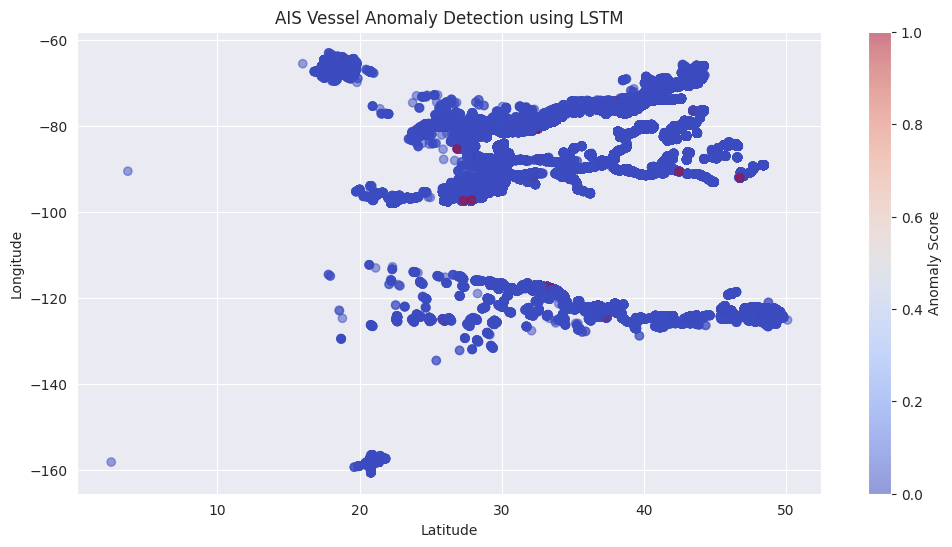

In [17]:
plt.figure(figsize=(12, 6))
plt.scatter(df['LAT'], df['LON'], c=df['Anomaly'], cmap='coolwarm', alpha=0.5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("AIS Vessel Anomaly Detection using LSTM")
plt.colorbar(label="Anomaly Score")
plt.show()
